In [2]:
# Importing required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
sns.set_style('darkgrid')

### Reading the csv files

In [3]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

### Checking for any data issues

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB


In [6]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


- Data in each file does not have null values and in proper format as well

### Merge tables

In [7]:
# Apply inner join on transaction with Customers table on CustomerID and Product table on ProductID
master_table = transactions.merge(customers, how='left', on='CustomerID').merge(products, how='left', on='ProductID')

In [8]:
master_table.isna().sum().sum()

0

> No null values present in the data

>#### On Going through the data, It is found that some of the users has done transactions before Signing up (TransactionDate < SignupDate) which should not be possible, therefore Removing those rows

In [9]:
# Filtering out rows where SignupDate <= TransactionDate
master_table = master_table.query('TransactionDate >= SignupDate')

#### `Price_x` and `Price_y` are same, dropping one column and renaming the second column

In [10]:
master_table = master_table.drop('Price_y',axis=1,errors='ignore').rename(columns={'Price_x':'Price'})

In [11]:
master_table.head(3)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate,ProductName,Category
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics


In [12]:
# Converting Datatype of SignupDate and TransactionDate to DateTime
master_table['SignupDate'] = pd.to_datetime(master_table['SignupDate'])
master_table['TransactionDate'] = pd.to_datetime(master_table['TransactionDate'])

#### Feature Engineering/Extraction

In [13]:
# Extracting day of Transaction, Month of Transaction, Month number of Transaction from TransactionDate column
master_table.insert(6,'TransactionDay',master_table['TransactionDate'].dt.day_name())
master_table.insert(4,'TransactionMonth',master_table['TransactionDate'].dt.month_name())
master_table.insert(5,'TransactionMonthNum',master_table['TransactionDate'].dt.month)

In [14]:
master_table.sort_values(by=['TransactionMonthNum'],inplace=True)

In [15]:
master_table.describe()

,TransactionDate,TransactionMonthNum,Quantity,TotalValue,Price,SignupDate
count,799,799.000000,799.000000,799.000000,799.000000,799
mean,2024-07-10 16:42:35.489361664,6.829787,2.521902,688.644193,273.840250,2023-03-28 22:55:07.133917440
min,2023-12-31 03:27:43,1.000000,1.000000,16.080000,16.080000,2022-01-22 00:00:00
25%,2024-04-19 18:38:48.500000,4.000000,2.000000,295.010000,147.950000,2022-06-17 12:00:00
50%,2024-07-19 10:56:13,7.000000,3.000000,580.340000,300.680000,2023-03-11 00:00:00
75%,2024-10-02 04:41:29.500000,10.000000,4.000000,1009.590000,416.350000,2023-12-19 12:00:00
max,2024-12-28 11:00:00,12.000000,4.000000,1991.040000,497.760000,2024-11-22 00:00:00
std,NaN,3.381516,1.120199,494.049091,141.012685,NaN


#### Outlier Detection

<Axes: ylabel='Quantity'>

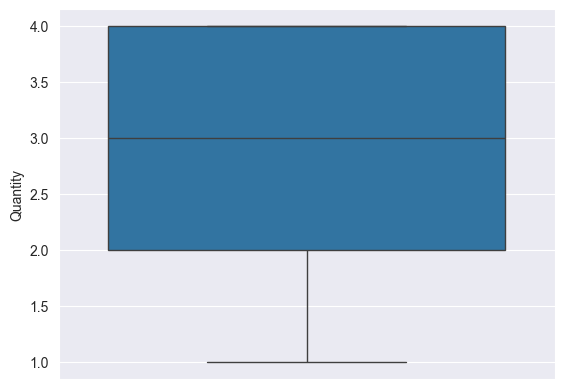

In [16]:
sns.boxplot(master_table['Quantity'])

<Axes: ylabel='Price'>

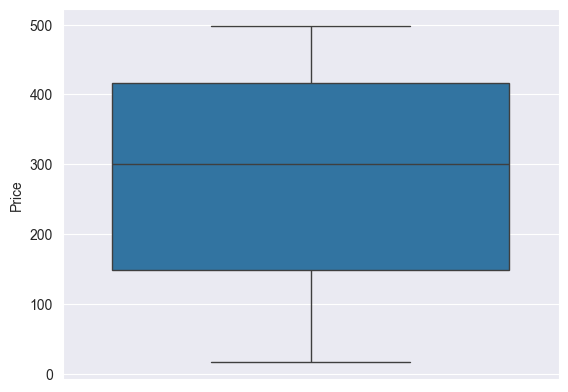

In [17]:
sns.boxplot(master_table['Price'])

<Axes: ylabel='TotalValue'>

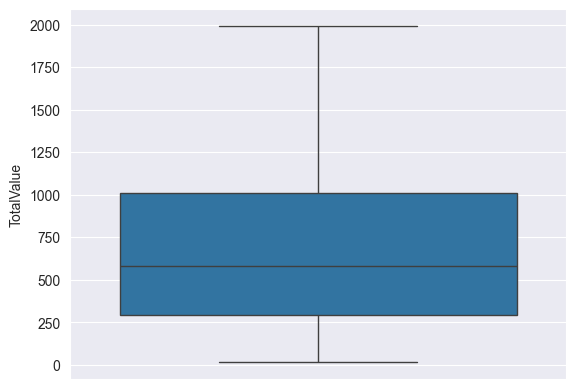

In [18]:
sns.boxplot(data=master_table['TotalValue'])

## Univariate Analysis

In [ ]:
# Create the pie chart
fig = px.pie(
    master_table.groupby('Region')['TransactionID'].count().reset_index(),
    values='TransactionID',  # Numerical values
    names='Region',       # Categories for the pie
    title="Distribution by Region",
    hole=0.5             # To make it a donut chart
)
fig.update_traces(textposition='outside',textinfo='percent+label')
fig.show()

- South America accounts for 1/3rd of the total sales across all the 4 Regions.
- All the other Regions are shows similar sales.
- This signifies that introducing new products in South America region will have better sales compared to other regions.

In [36]:
# Create the pie chart
fig = px.pie(
    master_table.groupby('Category')['TotalValue'].sum().reset_index(),
    values='TotalValue',  # Numerical values
    names='Category',       # Categories for the pie
    title="Total Sales by Category",
    hole=0.5           # Optional: To make it a donut chart
)

fig.update_traces(textposition='inside',textinfo='percent+label')

fig.show()

- Books category are the most sold items accounting for almost 1/3rd of the total sales combined.
- The least sold Category is Home decor aggregating 21% of total sales.

### Multi-Variate Analysis

In [21]:
fig = px.bar(
    data_frame=master_table.groupby(['Category','TransactionDay'])['Quantity'].sum().reset_index(), 
    x='TransactionDay', 
    y='Quantity', 
    barmode='stack',
    color='Category',
    title='Total Quantity of Products sold on different days',
    text_auto=True)

fig.show()

- Wednesday has the highest total quantity (~320), with Books (125) contributing the most, followed by Electronics (57).
- Sunday and Thursday also exhibit strong performance (~300 each), driven primarily by Electronics (83 on Sunday, 73 on Thursday).
- Friday and Saturday show lower sales (~250 each), with Books and Electronics leading in these categories.
- Home Decor consistently contributes the least, peaking at 80 on Thursday.
- Overall, Books and Electronics are the dominant categories, with Wednesday being the best sales day.

In [22]:
fig = px.bar(
    data_frame=master_table.groupby(['Category','TransactionDay'])['TotalValue'].sum().reset_index(), 
    x='TransactionDay', 
    y='TotalValue', 
    barmode='stack',
    color='Category',
    labels={'TotalValue':'Sales','TransactionDay':'Week Day'},
    title='Total Sales on Different Day',
    text_auto=True)

fig.show()

- Wednesday records the highest total sales (~80k), driven largely by Books (~38k).
- Friday, Monday, and Thursday also show substantial sales (~60-70k), with balanced contributions across all categories.
- Saturday and Sunday exhibit lower sales (~50k), with Electronics being a significant driver on Sunday (~22.4k).
- Home Decor contributes consistently less across all days, peaking at ~19k on Monday.
- This suggests mid-week (Wednesday) as the optimal sales day, with Books being the dominant product category.

In [23]:
master_table.groupby('Category')['Price'].mean()

Category
Books          283.379336
Clothing       281.166354
Electronics    290.700850
Home Decor     238.142448
Name: Price, dtype: float64

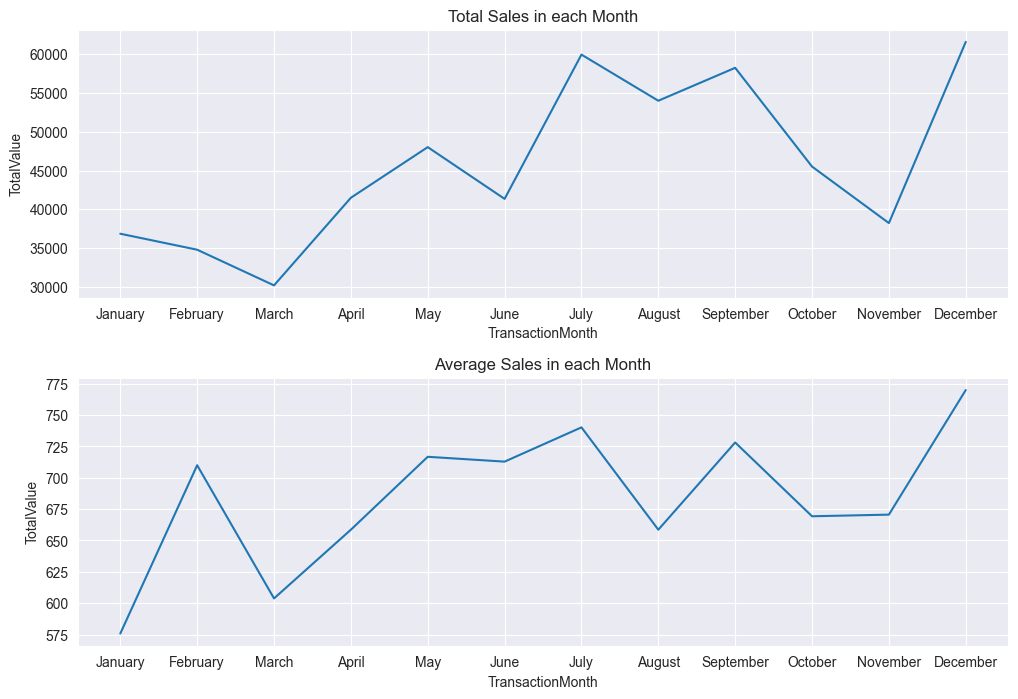

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
sns.lineplot(x=master_table['TransactionMonth'], y=master_table['TotalValue'],estimator='sum',errorbar=None, ax=axes[0])
axes[0].set_title('Total Sales in each Month')

sns.lineplot(data=master_table, x='TransactionMonth', y='TotalValue',estimator='mean',errorbar=None,markers=True,ax=axes[1])
axes[1].set_title('Average Sales in each Month')

# Increase the gap between subplots
plt.subplots_adjust(hspace=0.3)

- The data shows monthly total and average sales across a year, with total sales peaking at 60,000 in July and hitting its lowest point around 30,000 in March.  
- The average sale value ranges from 575 to 775, with the highest averages occurring in December and February. Despite fluctuations throughout the year, both metrics demonstrate clear seasonal patterns with strong performance in summer months (May-September) and during the December holiday season, while early spring shows consistently weaker results.  
- The total sales and average sales patterns don't always align, suggesting variations in both transaction volume and value throughout the year.

In [25]:
summarized_sales = master_table.groupby(['Region','Category'])[['TotalValue']].sum()

In [39]:
# Reset index to make Region and Category columns

# Create a grouped bar chart
fig = px.bar(
    summarized_sales.reset_index(),
    x='Category',
    y='TotalValue',
    color='Region',
    barmode='stack',
    title="Total Sales by Category",
    labels={'TotalValue': 'Total Sales'},
    text_auto=True
)

fig.show()


- South America encounters highest sales (~ 190.8K) Books and Electronics generating most of the sales.
- North America saw the lowest sales (~ 105.5K) amongst all the regions
- Asia and Europe shows balanced sales overall.
- Books dominate 3 out of 4 regions showcasing potential in high sales.
- Meanwhile, Clothing Products dominates the sales in Asian Continent.
- Home Decor generated the lesast amount of sales overall combined.

In [27]:

# Create a grouped bar chart
fig = px.bar(
    master_table.groupby(['Region','TransactionDay'])[['TotalValue']].sum().reset_index(),
    x='Region',
    y='TotalValue',
    color='TransactionDay',
    barmode='group',
    title="Total Sales by Region and Day",
    labels={'TotalValue': 'Total Sales'},
    text_auto=True
)
fig.show()

**Regional Performance:** South America appears to be the strongest performing region overall, with consistently high sales across most days
Asia and Europe show moderate performance levels
North America has the lowest overall sales numbers among the regions


**Day-by-Day Analysis:** Friday is particularly strong in South America (around 33k sales)
Wednesday shows high performance across most regions
Sunday tends to have lower sales volumes in most regions
Monday and Thursday show considerable variation between regions


**Notable Highlights:** The highest single bar appears to be Friday in South America at approximately 33k sales
Asia shows a notable spike on Wednesday at around 27k sales
North America's sales are more evenly distributed across days compared to other regions

In [28]:
summarized_quantity = master_table.groupby(['Region','Category'])[['Quantity']].sum()
# Create a grouped bar chart
fig = px.bar(
    summarized_quantity.reset_index(),
    x='Region',
    y='Quantity',
    color='Category',
    barmode='group',
    title="Total Product Quantity Sold by Region",
    labels={'TotalValue': 'Total Sales'},
    text_auto=True
)

fig.show()

South America stands out as the strongest performing region overall, leading in nearly every category
South America shows particularly strong book sales at 209 units
Asia performs well in clothing sales with 143 units
North America generally shows lower numbers across categories

Books perform consistently well across regions, with exceptional performance in South America
Electronics show strong numbers in South America (178 units) but are relatively consistent in other regions
Clothing sales vary significantly between regions, from 88 units in Europe to 143 in Asia
Home Decor shows a notable range from 83 units in North America to 160 in South America


South America leads in 3 out of 4 categories (Books, Electronics, and Home Decor)
Asia leads in Clothing sales
North America shows the lowest numbers in most categories
Europe maintains moderate performance across all categories